# Regression Models and Complementary Datasets (Continued)
**Project**: M4 Project 4
**Author**: Jacob Buysse

In this project we will be performing regression modeling on home sale pricing and them combining that dataset with a complimentary dataset to see how it might improve the model performance.

In this notebook we will be using...

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

We will configure our plots for readable labels, high resolution, and automatic layout.

In [2]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

## Part IV

Now we will try to engineer new features from the existing ones that might be better predictors.

In [3]:
df = pd.read_feather("./kc_house_data-comp.feather")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20873 entries, 0 to 20872
Data columns (total 96 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   index                     20873 non-null  int64   
 1   id                        20873 non-null  int64   
 2   date                      20873 non-null  object  
 3   price                     20873 non-null  float64 
 4   bedrooms                  20873 non-null  category
 5   bathrooms                 20873 non-null  float64 
 6   sqft_living               20873 non-null  int64   
 7   sqft_lot                  20873 non-null  int64   
 8   floors                    20873 non-null  float64 
 9   waterfront                20873 non-null  category
 10  view                      20873 non-null  category
 11  condition                 20873 non-null  category
 12  grade                     20873 non-null  category
 13  sqft_above                20873 non-null  int6

### Date Features

Instead of using the years the property was sold, built, and renovated - let us instead convert them to ages.

In [4]:
df["age"] = df.yr_sold - df.yr_built
df.age.value_counts()

age
 9      453
 0      429
 8      429
 11     421
 10     413
       ... 
 113     28
 115     26
 80      20
 81      19
-1       12
Name: count, Length: 117, dtype: int64

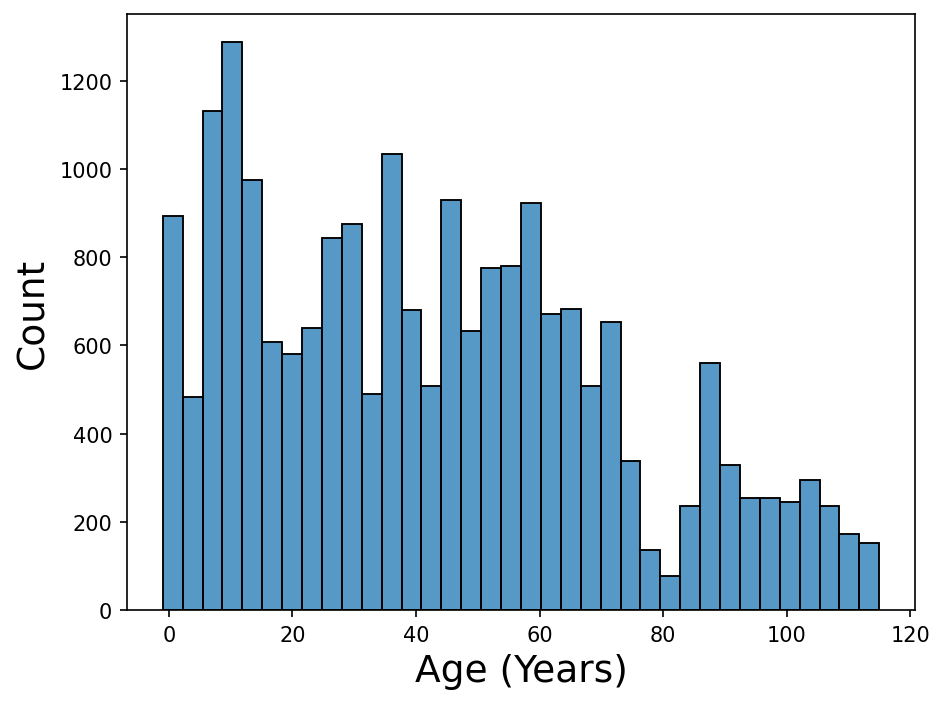

In [5]:
age_plot = sns.histplot(df.age)
age_plot.set(xlabel="Age (Years)", ylabel="Count");

Now let us compute the years since the last remodel.  This should allow us to remove the large bucket of homes that have never been remodeled by handling the zero value.

In [6]:
df["years_since_remodel"] = [
    row.yr_sold - row.yr_built\
    if row.yr_renovated == 0\
    else row.yr_sold - row.yr_renovated\
    for index, row in df.iterrows()
]
df.years_since_remodel.value_counts()

years_since_remodel
 0      514
 9      478
 8      466
 11     452
 10     444
       ... 
 113     27
 115     21
-1       18
 81      14
 80      12
Name: count, Length: 117, dtype: int64

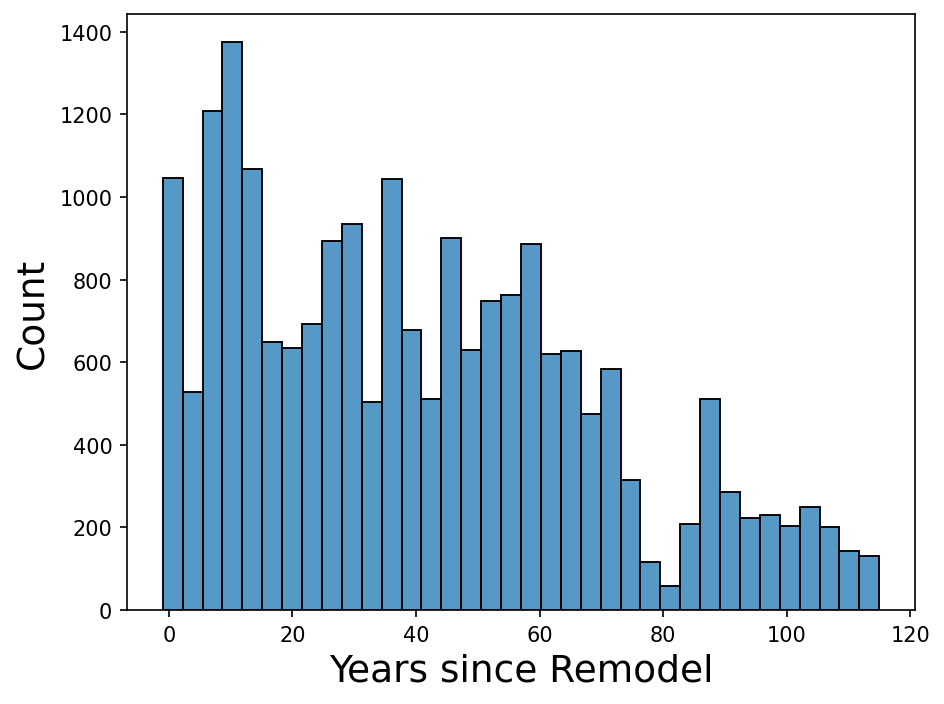

In [7]:
ysr_plot = sns.histplot(df.years_since_remodel)
ysr_plot.set(xlabel="Years since Remodel", ylabel="Count");

This plot is nearly identical to the age plot.  Let us subtract the two to give us a "years of the house that have been remodeled away" number.

### Room Features

From a previous project, we know that the product of the number of bedrooms and bathrooms can help model a non-linear relationship.  Since we also know that there might be zero whole bathrooms, we will add one to prevent over-inflating a zero bucket.

In [8]:
df["beds_baths"] = df.bedrooms.astype(int) * (df.whole_bathrooms.astype(int) + 1)
df.beds_baths.value_counts()

beds_baths
6     4893
12    4833
9     4602
4     2098
8     1291
16     984
15     732
20     610
10     218
2      177
25     100
18      95
24      94
30      50
1       25
3       24
28      11
35      11
21       8
36       6
32       5
14       3
48       1
40       1
42       1
Name: count, dtype: int64

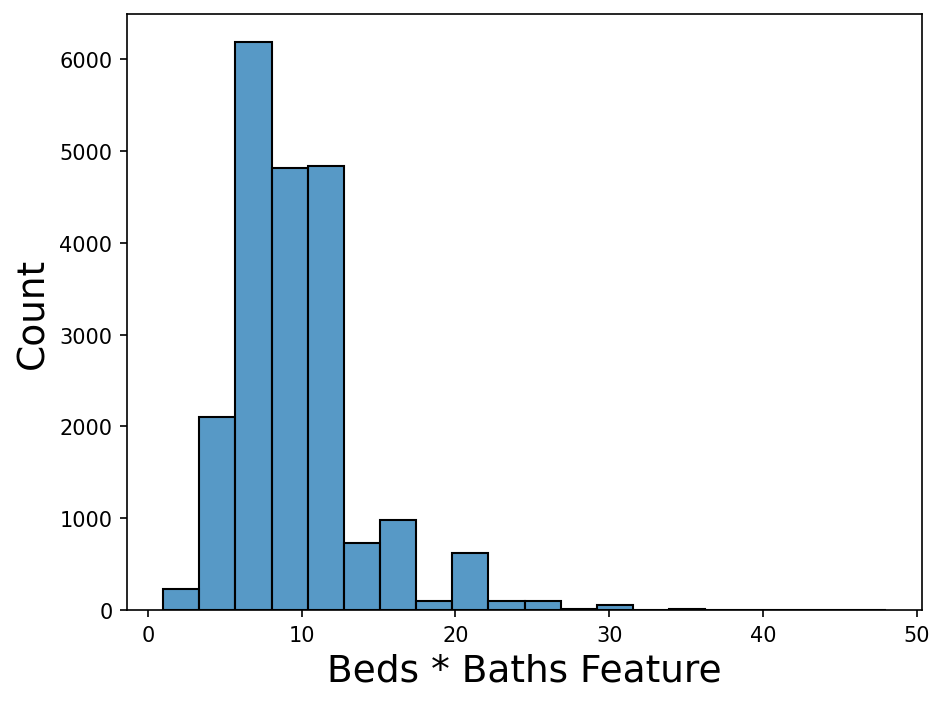

In [9]:
bb_plot = sns.histplot(df.beds_baths, bins=20)
bb_plot.set(xlabel="Beds * Baths Feature", ylabel="Count");

### Grade

We know from the description that grades above 10 are high quality.

In [10]:
df["high_quality"] = [0 if value < 11 else 1 for value in df.grade.astype(int)]
df.high_quality = df.high_quality.astype("category")
df.high_quality.value_counts()

high_quality
0    20463
1      410
Name: count, dtype: int64

### Square Footage - Binning

Using the square footage (total, above ground, basement, lot size) as a number is fine, but let us augment this with bins for different sizes.

First, we need to get our training split so we can use just that subset for figuring out the bins.

In [11]:
price_bins = np.histogram_bin_edges(df.price, bins=[0, 100000, 200000, 300000, 500000, 700000, 1000000, 1500000, 2000000, 3000000, 4000000])
price_bin_inds = np.digitize(df.price, price_bins)
train_df, test_df = train_test_split(df, train_size=0.75, random_state=777, stratify=price_bin_inds)

Let us create bins (default size is 5) for the living, lot, and above square foot features.

In [12]:
sqft_fn = KBinsDiscretizer()
sqft_features = ["sqft_living", "sqft_lot", "sqft_above"]
sqft_fn.fit(train_df[sqft_features])
sqft_train_X = sqft_fn.transform(train_df[sqft_features])
sqft_test_X = sqft_fn.transform(test_df[sqft_features])
print(f"train {sqft_train_X.shape}, test {sqft_test_X.shape}")

train (15654, 15), test (5219, 15)


We can't use the standard bins for basement since the majority do not have basements.  Instead, let us add a bool feature for "no basement" and just bin the remaining values for basement.

In [13]:
base_fn = KBinsDiscretizer()
mask_none = train_df.sqft_basement == 0
base_fn.fit(train_df[["sqft_basement"]][~mask_none])
nobase_train_X = pd.DataFrame(pd.Series(mask_none, dtype=int))
nobase_test_X = pd.DataFrame(pd.Series(test_df.sqft_basement == 0, dtype=int))
base_train_X = base_fn.transform(train_df[["sqft_basement"]])
base_test_X = base_fn.transform(test_df[["sqft_basement"]])
print(f"train {nobase_train_X.shape} {base_train_X.shape}, test {nobase_test_X.shape} {base_test_X.shape}")

train (15654, 1) (15654, 5), test (5219, 1) (5219, 5)


### 2-Dimensional Binning

Let us use `KMeans` to perform 2-dimensional binning for the latitude longitude.

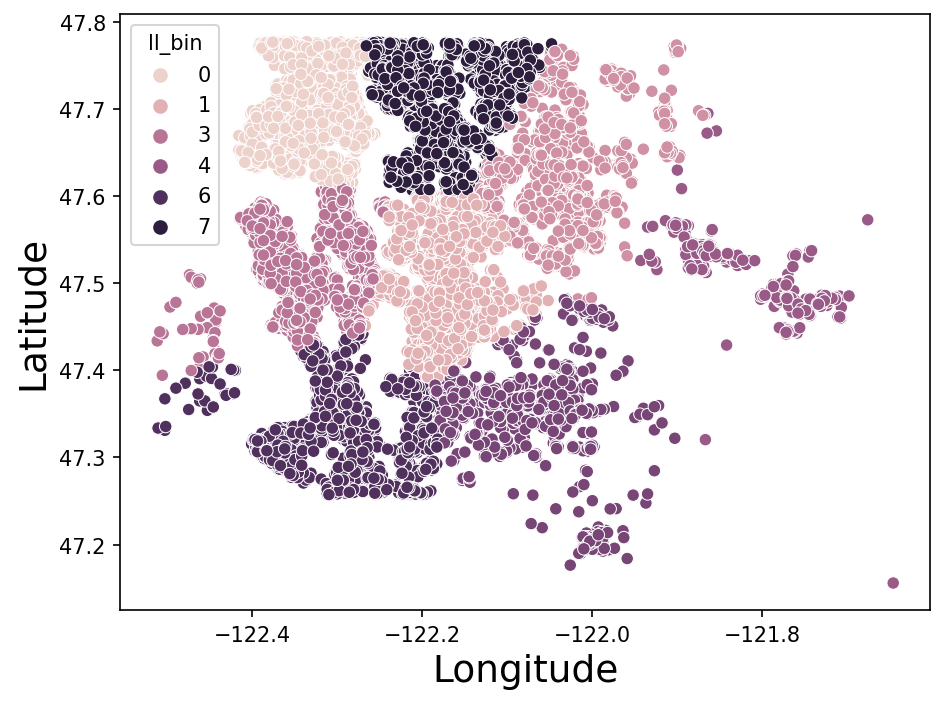

In [14]:
ll_fn = KMeans(n_init="auto", random_state=777)
ll_features = ["lat", "long"]
ll_fn.fit(train_df[ll_features])
train_df["ll_bin"] = ll_fn.predict(train_df[ll_features])
test_df["ll_bin"] = ll_fn.predict(test_df[ll_features])

ll_plot = sns.scatterplot(data=train_df, x="long", y="lat", hue="ll_bin")
ll_plot.set(xlabel="Longitude", ylabel="Latitude");

### Generate train/test datasets

Let us combined the different parts into a comprehensive training and test dataset.  First, the one-hot-encoding.

In [15]:
hot_enc = OneHotEncoder()
cat_features = [
    "bedrooms", "waterfront", "view", "condition", "grade", "zipcode",
    "whole_bathrooms", "partial_bathroom", "whole_floors", "partial_floors",
    "high_quality", "ll_bin"
]
hot_enc.fit(train_df[cat_features])
train_hot = hot_enc.transform(train_df[cat_features])
test_hot = hot_enc.transform(test_df[cat_features])

Next, we scale the numeric features.

In [16]:
scaler = StandardScaler()
num_features = [
    "sqft_living", "sqft_lot", "sqft_above", "sqft_basement",
    "yr_built", "yr_renovated", "lat", "long", "yr_sold",
    "age", "years_since_remodel", "beds_baths"
] + df.columns[df.columns.str.contains("pop_")].values.tolist() +\
    df.columns[df.columns.str.contains("ENROLLMENT_")].values.tolist() +\
    df.columns[df.columns.str.contains("FULL_TIME__")].values.tolist()
scaler.fit(train_df[num_features])
train_num = scaler.transform(train_df[num_features])
test_num = scaler.transform(test_df[num_features])

And finally we combined all of the datasets into X,y for train and test.

In [17]:
train_X = sp.hstack((train_hot, train_num, sqft_train_X, nobase_train_X, base_train_X))
train_y = train_df.price.values
test_X = sp.hstack((test_hot, test_num, sqft_test_X, nobase_test_X, base_test_X))
test_y = test_df.price.values
print(f"Train X {train_X.shape}, y {len(train_y)}")
print(f"Test X {test_X.shape}, y {len(test_y)}")

Train X (15654, 227), y 15654
Test X (5219, 227), y 5219


So we will be modeling 227 features instead of the previous 193.

### Ridge Regression - Take 3

In [18]:
model = Ridge(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $132,476, MAPE: 16.1%


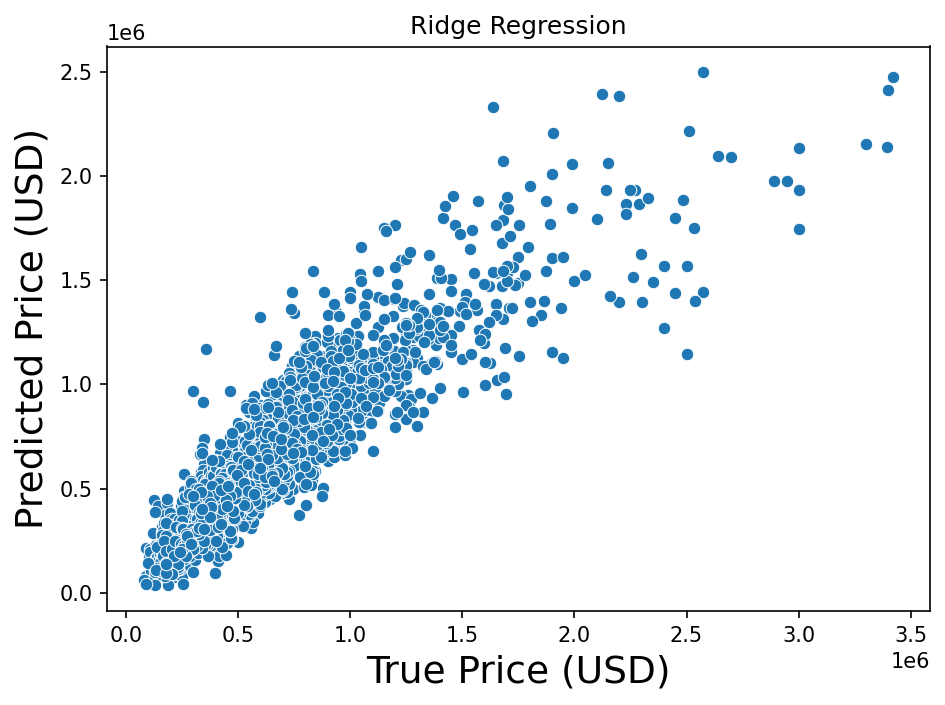

In [19]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="Ridge Regression");
pred_true_plot.figure.savefig("p3_ridge.png")

### SGD Regressor - Take 3

In [20]:
model = SGDRegressor(loss="huber", epsilon=50000, max_iter=10000, random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $148,277, MAPE: 14.8%


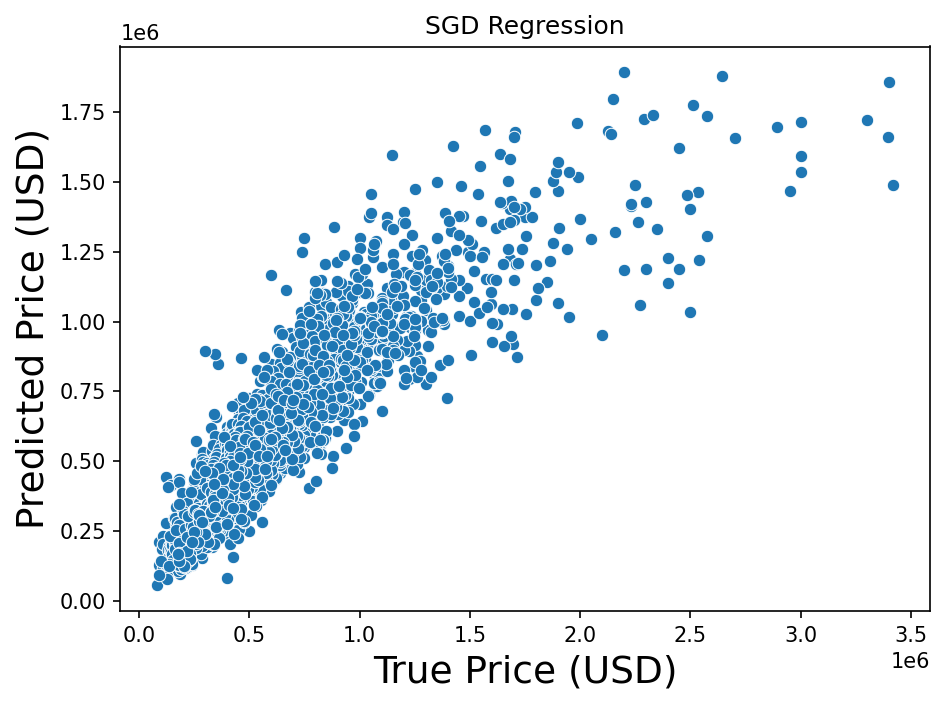

In [21]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="SGD Regression");
pred_true_plot.figure.savefig("p3_sgd.png")

### Random Forest Regressor - Take 3

In [22]:
model = RandomForestRegressor(max_depth=10, random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
mse = mean_squared_error(test_y, pred_y)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_y, pred_y)
print(f"RMSE (USD): ${rmse:,.0f}, MAPE: {mape:.1%}")

RMSE (USD): $120,388, MAPE: 14.0%


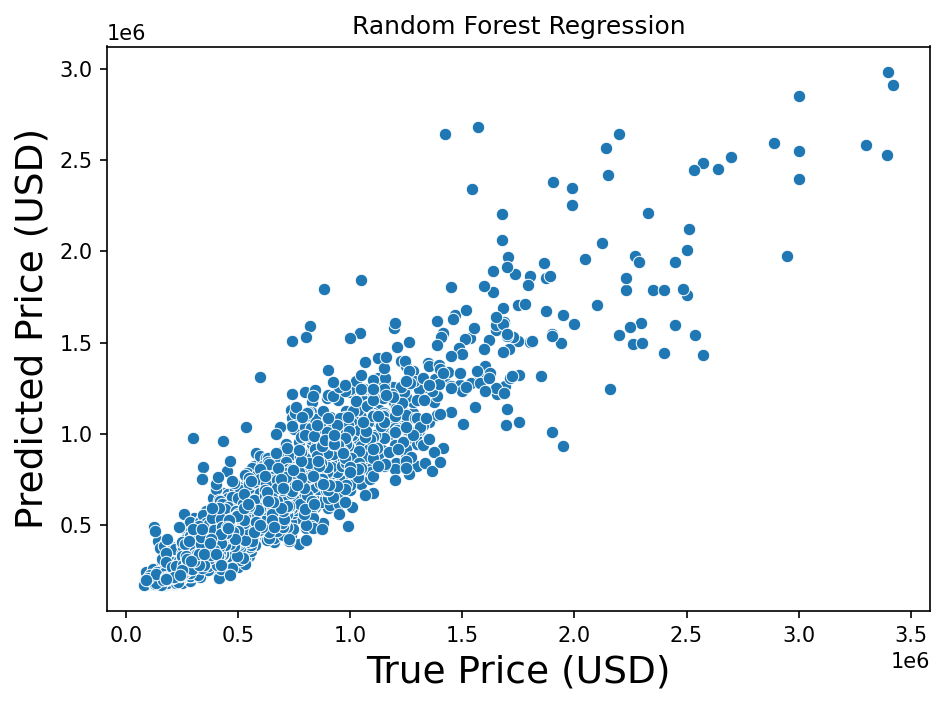

In [23]:
pred_true_plot = sns.scatterplot(x=test_y, y=pred_y)
pred_true_plot.set(xlabel="True Price (USD)", ylabel="Predicted Price (USD)", title="Random Forest Regression");
pred_true_plot.figure.savefig("p3_random_forest.png")